In [2]:
# Basic imports
import os
import math
import io
import sys
import copy
import requests
from natsort import natsorted 

# Plotting and logging imports
import matplotlib.pyplot as plt
import seaborn as sns

import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args('')

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

from tqdm.notebook import tqdm

# Image library imports
from PIL import Image
import PIL
import cv2
import imageio

# Numerical operations / Machine learning / Deep learning libraries
from sklearn import manifold, datasets, metrics
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms import functional as TF

# CLIP model imports
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

# From guided diffusion files
sys.path.append('./guided-diffusion')
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

# Make notebook full screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Set device based on availability
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")


/home/alexander/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Generating Class Conditional Samples with a Denoising Diffusion Probabilistic Model (DDPM)

In [14]:
# Random utility functions for managing data or logging
def plot_images(images):
    
    plt.figure(figsize=(32,32))
    plt.imshow(torch.cat([torch.cat([i for i in images.cpu()], dim=-1),
        ], dim=-2).permute(1,2,0).cpu())
    plt.show()

def save_images(images, path, **kwargs):
    
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1,2,0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)


def get_data(args):
    
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(80),
        torchvision.transforms.RandomResizedCrop(args.image_size, scale=(0.8,1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])
    dataset = torchvision.datasets.ImageFolder(args.dataset_path, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader

def setup_logging(run_name, args):
    
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name, "generated"), exist_ok=True)
    for i in range(args.num_classes):
        os.makedirs(os.path.join("results", run_name, "generated", args.class_names[i]), exist_ok=True)  

In [6]:
# EMA update definition (to prevent overfitting to recent samples)
class EMA: 

    def __init__(self, beta):

        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):

        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data 
            ma_params.data = self.update_average(old_weight, up_weight) 

    def update_average(self, old, new):

        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):

        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return

        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):

        ema_model.load_state_dict(model.state_dict())
        
# Self attention block 
class SelfAttention(nn.Module):

    def __init__(self, channels, size, attn_heads=4):
        super(SelfAttention, self).__init__()

        self.channels = channels
        self.size = size
        self.attn_heads = attn_heads


        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)

        self.ln = nn.LayerNorm([channels])

        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
            )

    def forward(self, x):

            x = x.view(-1, self.channels, self.size * self.size).swapaxes(1,2)
            x_ln = self.ln(x)

            intermediate, _ = self.mha(x_ln, x_ln, x_ln)

            intermediate = intermediate + x
            intermediate = self.ff_self(intermediate) + intermediate

            return intermediate.swapaxes(2,1).view(-1, self.channels, self.size, self.size)

# Convolutional block
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()

        self.residual = residual

        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
            )

    def forward(self, x):

        if self.residual:

            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

# Downscale block
class DownScale(nn.Module):

    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels * 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, t):

        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])

        return x + emb

# Upscale block
class UpScale(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, t):

        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])

        return x + emb

# UNet backbone for DDPM model
class UNet_conditional(nn.Module):
        def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda", bottleneck_size=512, num_classes=None, attn_heads=4):
            super().__init__()

            self.device = device
            self.time_dim = time_dim

            self.inc = DoubleConv(c_in, int(bottleneck_size/8))
            self.down1 = DownScale(int(bottleneck_size/8), int(bottleneck_size/4))
            self.sa1 = SelfAttention(int(bottleneck_size/4), int(bottleneck_size/16),   attn_heads)
            self.down2 = DownScale(int(bottleneck_size/4), int(bottleneck_size/2))
            self.sa2 = SelfAttention(int(bottleneck_size/2), int(bottleneck_size/32),   attn_heads)
            self.down3 = DownScale(int(bottleneck_size/2), int(bottleneck_size/2))
            self.sa3 = SelfAttention(int(bottleneck_size/2), int(bottleneck_size/64),   attn_heads)

            self.bot1 = DoubleConv(int(bottleneck_size/2), bottleneck_size)
            self.bot2 = DoubleConv(bottleneck_size, bottleneck_size)
            self.bot3 = DoubleConv(bottleneck_size, int(bottleneck_size/2))

            self.up1 = UpScale(bottleneck_size, int(bottleneck_size/4))
            self.sa4 = SelfAttention(int(bottleneck_size/4), int(bottleneck_size/32),   attn_heads)
            self.up2 = UpScale(int(bottleneck_size/2), int(bottleneck_size/8))
            self.sa5 = SelfAttention(int(bottleneck_size/8), int(bottleneck_size/16),   attn_heads)
            self.up3 = UpScale(int(bottleneck_size/4), int(bottleneck_size/8))
            self.sa6 = SelfAttention(int(bottleneck_size/8), int(bottleneck_size/8),   attn_heads)
            self.outc = nn.Conv2d(int(bottleneck_size/8), c_out, kernel_size=1)

            if num_classes is not None: 
                self.label_emb = nn.Embedding(num_classes, time_dim)
                
        # Positional encoding relative to noising schedule step
        def pos_encoding(self, t, channels):
            inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels))

            pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
            pos_enc_b = torch.cos(t.repeat(1, channels //2) * inv_freq)
            pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)

            return pos_enc
        
        # Forward pass
        def forward(self, x, t, y):

            t = t.unsqueeze(-1).type(torch.float)
            t = self.pos_encoding(t, self.time_dim)
            
            # if class conditional add to postional encoding as info seen by model 
            if y is not None:
                t += self.label_emb(y)
                
            # Downscale 
            x1 = self.inc(x)
            x2 = self.down1(x1, t)
            x2 = self.sa1(x2)
            x3 = self.down2(x2, t)
            x3 = self.sa2(x3)
            x4 = self.down3(x3, t)
            x4 = self.sa3(x4)
            
            # Bottleneck layers
            x4 = self.bot1(x4)
            x4 = self.bot2(x4)
            x4 = self.bot3(x4)
            
            # Upscale
            x = self.up1(x4, x3, t)
            x = self.sa4(x)
            x = self.up2(x, x2, t)
            x = self.sa5(x)
            x = self.up3(x, x1, t)
            x = self.sa6(x)

            output = self.outc(x)

            return output


In [21]:
# Actual diffusion model
class Diffusion:

    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):

        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)#
    
    # add noise to image relative to noise schedule position
    def noise_images(self, x, t):

        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1-self.alpha_hat[t])[:, None, None, None]
        eps = torch.randn_like(x)

        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    # sample model
    def sample(self, model, n, labels, cfg_scale=3):

        model.eval()

        with torch.no_grad():
            # Create starting noise
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            # Denoise over many steps
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                # Predict noise using UNet model
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else: 
                    noise = torch.zeros_like(x)
                # Remove predicted noise from image
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            model.train()
            x = (x.clamp(-1, 1) + 1) / 2
            x = (x * 255).type(torch.uint8)
            return x
        
# Train model
def train(args):
    
        # Setup
        setup_logging(args.run_name, args)
        device = args.device
        dataloader = get_data(args)
        model = UNet_conditional(num_classes=args.num_classes).to(device)
        
        optimizer = optim.AdamW(model.parameters(), lr=args.lr)
        mse = nn.MSELoss()
        diffusion = Diffusion(img_size=args.image_size, device=device)
        logger = SummaryWriter(os.path.join("runs", args.run_name))
        
        l = len(dataloader)
        ema = EMA(0.995)
        ema_model = copy.deepcopy(model).eval().requires_grad_(False)
        start_epoch = 0
        
        # Load pretrained or not?
        if args.from_ckpt:
            ckpt = torch.load("models/" +  args.run_name + "_joined_ckpt")
            model.load_state_dict(ckpt['model_state_dict'])
            optimizer.load_state_dict(ckpt['optimizer_state_dict'])
            ema_model.load_state_dict(ckpt['ema_state_dict'])
            start_epoch = ckpt['epoch'] + 1
        
        # Train for epochs
        for epoch in range(start_epoch, args.epochs):
            logging.info(f"Starting epoch {epoch}: ")
            pbar = tqdm(dataloader)
            for i, (images, labels) in enumerate(pbar):
                labels = labels.to(device)
                images = images.to(device)
                # Get rnadom timestep and noise amount relative to that postion
                t = diffusion.sample_timesteps(images.shape[0]).to(device)
                x_n, noise = diffusion.noise_images(images, t)
                
                # Don't always pass labels for more creative / generalizable learning
                if np.random.random() < 0.1:
                    labels = None
                
                # pred noise
                predicted_noise = model(x_n, t, labels)
                
                # Update ema_model weights
                ema.step_ema(ema_model, model)
                
                # loss between actual added noise and predicted noise
                loss = mse(noise, predicted_noise)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.set_postfix(MSE=loss.item())
                logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

            if epoch % 5 == 0:
                
                # logging / checkpoints
                labels = torch.arange(args.num_classes).long().to(device)
                sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
                ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
                save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
                save_images(ema_sampled_images, os.path.join("results", args.run_name, f"{epoch}_ema.jpg"))
                print('Saving checkpoint...')

                torch.save({'epoch':epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'ema_state_dict': ema_model.state_dict(),
                    }, "models/" +  args.run_name + "_joined_ckpt")
                
# Generate new samples from trained model    
def gen(args):
    
    device = args.device
    dataloader = get_data(args)
    model = UNet_conditional(num_classes=args.num_classes).to(device)

    diffusion = Diffusion(img_size=args.image_size, device=device)

    ckpt = torch.load("models/" +  args.run_name + "_joined_ckpt")
    
    if args.gen_from_ema:
        model.load_state_dict(ckpt['ema_state_dict'])
    else:
        model.load_state_dict(ckpt['model_state_dict'])
        
    labels = torch.arange(args.num_classes).long().to(device)
   
    for gen_num in range(0, args.generate_num):
        sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
        for i in range(args.num_classes):
            img = sampled_images[i]
            save_images(img, os.path.join("results", args.run_name, "generated", args.class_names[i], f"{gen_num}.jpg"))
        

In [19]:
args.run_name = "DDPM_conditional_fin"
args.from_ckpt = False
args.epochs = 5
args.batch_size = 6
args.image_size = 64
args.num_classes = 2
args.dataset_path = 'data/financial'
args.device = device
args.lr = 3e-4
args.class_names = ['Negative', 'Positive']
args.generate_num = 10
args.gen_from_ema = False

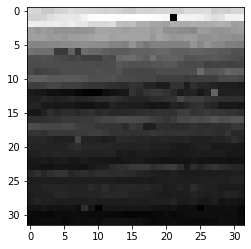

In [26]:
image_neg = cv2.imread('data/financial/Neg/8_-0.30120.png')
plt.imshow(image_neg)

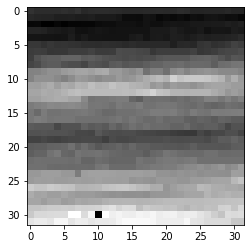

In [27]:
image_pos = cv2.imread('data/financial/Pos/16_0.25135.png')
plt.imshow(image_pos)

In [15]:
train(args)

01:35:53 - INFO: Starting epoch 0: 


  0%|          | 0/513 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Saving checkpoint...


01:39:24 - INFO: Starting epoch 1: 


  0%|          | 0/513 [00:00<?, ?it/s]

01:41:11 - INFO: Starting epoch 2: 


  0%|          | 0/513 [00:00<?, ?it/s]

01:43:04 - INFO: Starting epoch 3: 


  0%|          | 0/513 [00:00<?, ?it/s]

01:45:04 - INFO: Starting epoch 4: 


  0%|          | 0/513 [00:00<?, ?it/s]

In [22]:
gen(args)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

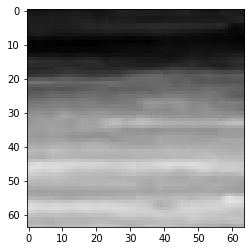

In [32]:
gen_pos = cv2.imread('data/demo/pos_gen.jpg')
plt.imshow(gen_pos)


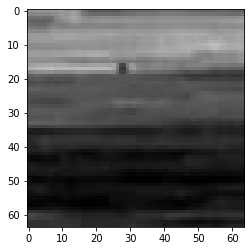

In [31]:
gen_neg = cv2.imread('data/demo/neg_gen.jpg')
plt.imshow(gen_neg)

# Generating Images with Guidance from CLIP

In [12]:
# Load CLIP model, tokenizer, and image pre-processor
model_id = "openai/clip-vit-base-patch16"

tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
clip_model = CLIPModel.from_pretrained(model_id).to(device)

In [3]:
# Test it on a basic text prompt
prompt = "a baby tiger standing in a field."

# create transformer-readable tokens
inputs = tokenizer(prompt, return_tensors="pt").to(device)
inputs

{'input_ids': tensor([[49406,   320,  1794,  6531,  2862,   530,   320,  1570,   269, 49407]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [4]:
text_emb_tiger = clip_model.get_text_features(**inputs)
text_emb_tiger.shape

torch.Size([1, 512])

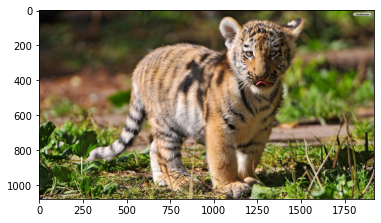

In [17]:
# Test on a basic image
image_tiger = cv2.imread('data/demo/baby_tiger.jpeg')
image_tiger = cv2.cvtColor(image_tiger, cv2.COLOR_BGR2RGB)
plt.imshow(image_tiger)

In [18]:
image_tiger = processor(
    text=None,
    images=image_tiger,
    return_tensors='pt'
)['pixel_values'].to(device)
image_tiger.shape

torch.Size([1, 3, 224, 224])

In [7]:
img_emb_tiger = clip_model.get_image_features(image_tiger)
img_emb_tiger.shape

torch.Size([1, 512])

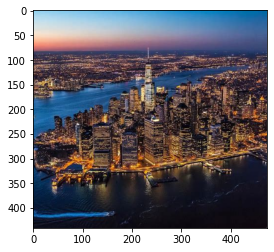

In [3]:
# Another pair of prompt / image
prompt_manhattan = "the city of manhattan at night from above."
inputs_manhattan = tokenizer(prompt_manhattan, return_tensors="pt").to(device)
text_emb_manhattan =clip_model.get_text_features(**inputs_manhattan)

image_manhattan = cv2.imread('data/demo/manhattan.jpeg')
image_manhattan = cv2.cvtColor(image_manhattan, cv2.COLOR_BGR2RGB)
plt.imshow(image_manhattan)
image_manhattan = processor(
    text=None,
    images=image_manhattan,
    return_tensors='pt'
)['pixel_values'].to(device)
img_emb_manhattan = clip_model.get_image_features(image_manhattan)

In [9]:
points_all = torch.cat((img_emb_tiger, text_emb_tiger, img_emb_manhattan, text_emb_manhattan), 
                       axis=0).cpu().detach().numpy()
points_all.shape
points_all = points_all / np.linalg.norm(points_all, axis=0)

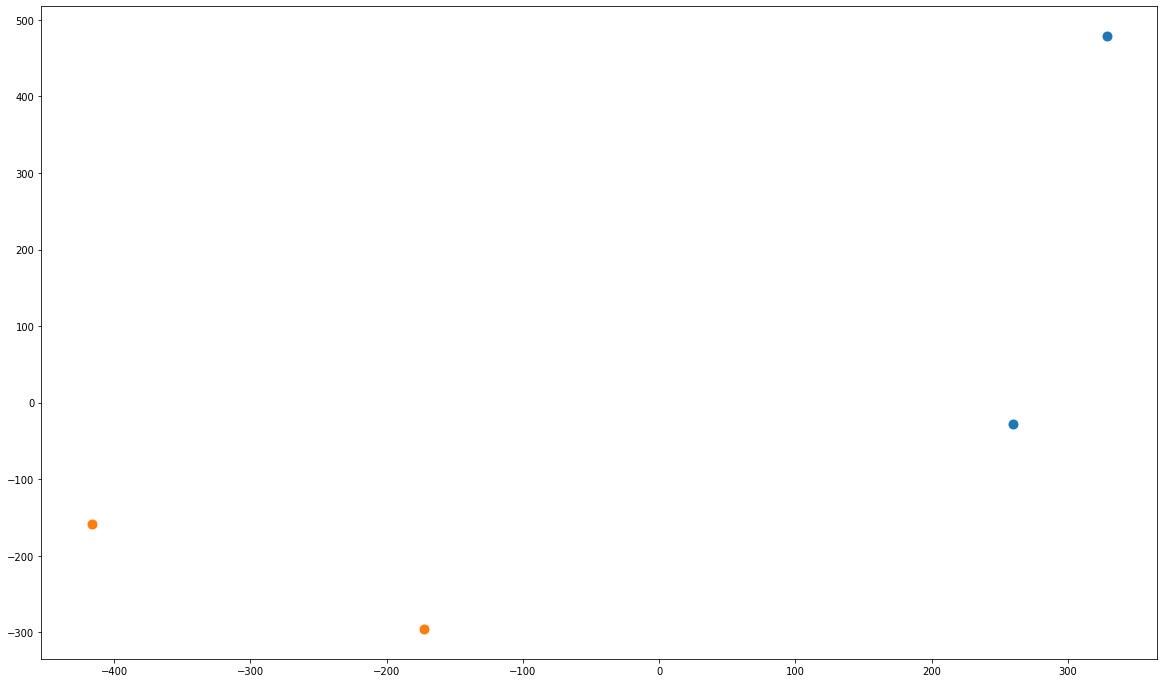

In [10]:
# Plot embeddings in 2D using t-SNE for dimensionality reduction
tsne = manifold.TSNE(n_components=3, perplexity=40, random_state=0).fit_transform(
    points_all
)

plt.figure(figsize=(20,12))
sns.scatterplot(x=tsne[:2, 0], y=tsne[:2, 1], palette=['red'], s=120)
sns.scatterplot(x=tsne[2:, 0], y=tsne[2:, 1], palette=['blue'], s=120)
plt.show()

<AxesSubplot:>

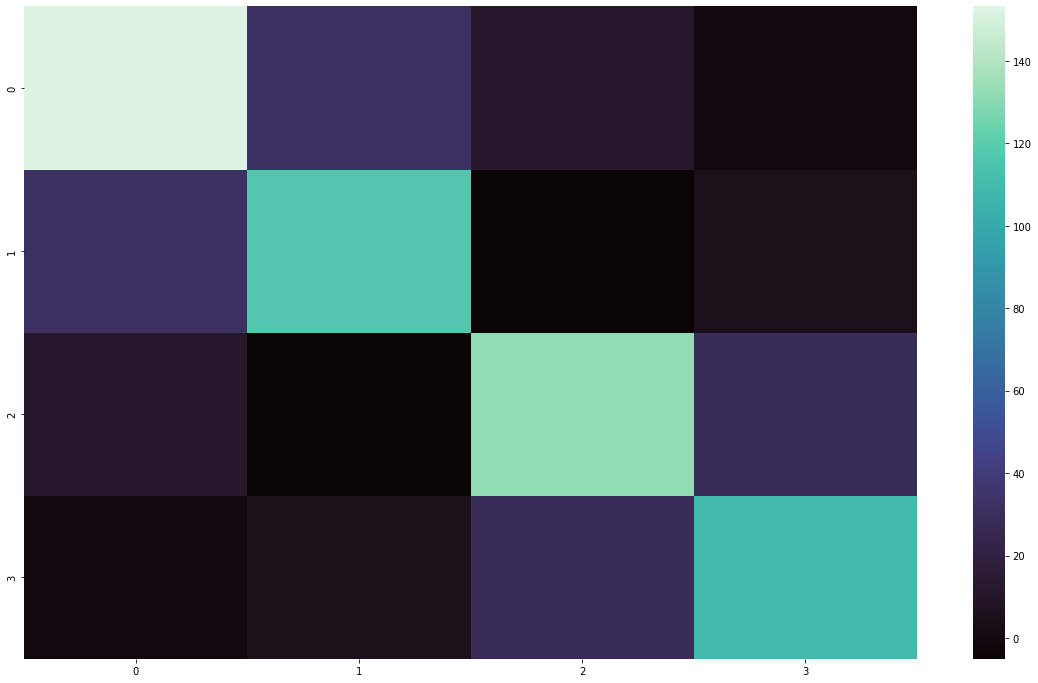

In [11]:
# Compare distance between both sets of prompts / images
plt.figure(figsize=(20,12))
sns.heatmap(np.dot(points_all, points_all.T), cmap="mako")

In [2]:
# Download pretrained model checkpoints (there are others available to use with this same architecture at https://github.com/openai/guided-diffusion)
# !curl -OL 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion.pt'
# !curl -OL 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/lsun_cat.pt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  3 2108M    3 83.6M    0     0   452k      0  1:19:27  0:03:09  1:16:18  134k0     0   470k      0  1:16:32  0:02:58  1:13:34  338k^C


In [21]:
# This is for using the OG clip model rather than other versions from HuggingFace

# If you don't already have it
#!git clone https://github.com/openai/CLIP
#!pip3 install -e ./CLIP

use_hugging_face_CLIP = False
if use_hugging_face_CLIP:
    
    model_id = "openai/clip-vit-base-patch16"

    tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
    processor = CLIPProcessor.from_pretrained(model_id)
    clip_model = CLIPModel.from_pretrained(model_id).to(device)
    clip_model.eval().requires_grad_(False).to(device)
    
else:
    
    sys.path.append('./CLIP')

    import clip

    clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
    clip_size = clip_model.visual.input_resolution
    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                     std=[0.26862954, 0.26130258, 0.27577711])

In [22]:
checkpoint_name = 'lsun_cat.pt'
if checkpoint_name == '256x256_diffusion.pt':
    class_conditional_model = True
else:
    class_conditional_model = False

In [23]:
# If using 256x256 set class_cond to True, if lsun_cat set to False
model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': class_conditional_model,
    'diffusion_steps': 1000, 
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})

In [24]:
# Load diffusion model from checkpoints and set to eval
model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(checkpoint_name, map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

In [43]:
# Guiding hyperparameters
prompt = "a blue cat"       # The mighty prompt ... wow (」･o･)」
batch_size = 1
clip_guidance_scale = 1400  # Controls how much the image should look like the prompt.
tv_scale = 150              # Controls the smoothness of the final output.
cutn = 40                   # Controls how many cuts to make from the image
cut_pow = 0.5
n_batches = 1               # How many images to generate in a row (really should be more like default 15)

"""
init_image = None  
skip_timesteps = 0
"""

init_image = 'data/demo/baby_tiger.jpeg'  # Can be URL or local path
skip_timesteps = 200  # This needs to be between approx. 200 and 500 when using an init image. (Higher values make the output look more like the init.) 

# Random seed
seed = 0.5

if use_hugging_face_CLIP:
    # Cut size 
    clip_size = 224

    # scaling params 
    new_min, new_max = 0, 1

# Make directories for results
os.makedirs("results", exist_ok=True)
os.makedirs(os.path.join("results", "guided"), exist_ok=True)
os.makedirs(os.path.join("results", "guided", 'all'), exist_ok=True)
os.makedirs(os.path.join("results", "guided", 'all',prompt.replace(" ", "_")), exist_ok=True)

In [26]:
# Random helper functions
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

# Cut image into sub images
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

# Loss between prompt / image embeddings
def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

# Total variance loss (encourage smoothness)
def tv_loss(input):
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


In [31]:
# Actually run the guided diffusion process

def guided_diffusion_run():
    if seed is not None:
        torch.manual_seed(seed)
        
    # Get prompt embedding
    if use_hugging_face_CLIP:
        text_tokens = tokenizer(prompt, return_tensors="pt").to(device)
        text_embed =  clip_model.get_text_features(**text_tokens).to(device).float()
    else:
        text_embed = clip_model.encode_text(clip.tokenize(prompt).to(device)).float() 
    
    # If you are uisng an image to guide also:
    init = None
    if init_image is not None:
        init = Image.open(fetch(init_image)).convert('RGB')
        init = init.resize((model_config['image_size'], model_config['image_size']), Image.LANCZOS)
        #display(init)
        init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)
        
    # Define cutout function
    make_cutouts = MakeCutouts(clip_size, cutn, cut_pow)

    cur_t = None

    def cond_fn(x, t, y=None):
        with torch.enable_grad():
            x = x.detach().requires_grad_()
            n = x.shape[0]
            
            # get timestep for noise, take prediction, and remove that noise
            my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
            out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
            fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
            x_in = out['pred_xstart'] * fac + x * (1 - fac)
            
            # Get image embeddings from cutouts of the generated image at current step
            if use_hugging_face_CLIP:
                v_min, v_max = clip_in.min(), clip_in.max()
                clip_in = ((clip_in - v_min)/(v_max - v_min)*(new_max - new_min) + new_min)
                clip_in = make_cutouts(clip_in)
                image_tokens = processor(
                    text=None,
                    images=clip_in,
                    return_tensors='pt'
                )['pixel_values'].to(device)
                image_embeds = clip_model.get_image_features(image_tokens).float()
            else:
                clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
                image_embeds = clip_model.encode_image(clip_in).float().view([cutn, n, -1])
                
            # Losses
            dists = spherical_dist_loss(image_embeds, text_embed.unsqueeze(0))
            losses = dists.mean(0)
            tv_losses = tv_loss(x_in)
            loss = losses.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale
            return -torch.autograd.grad(loss, x)[0]

    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive
    
    # Run model the number of times you specified for n_batches and save
    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1
        if class_conditional_model:
            kwargs = {'y': torch.zeros([batch_size], device=device, dtype=torch.long)}
        else: 
            kwargs = {}
        samples = sample_fn(
            model,
            (batch_size, 3, model_config['image_size'], model_config['image_size']),
            clip_denoised=False,
            model_kwargs=kwargs,
            cond_fn=cond_fn,
            progress=True,
            skip_timesteps=skip_timesteps,
            init_image=init,
            randomize_class=True,
        )

        for j, sample in enumerate(samples):
            for k, image in enumerate(sample['pred_xstart']):
                filename = 'results/guided/all/' + prompt.replace(" ", "_") + '/' + str(j) + '.png'
                TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
            cur_t -= 1
            if j % 100 == 0 or cur_t == -1:
                print()
                for k, image in enumerate(sample['pred_xstart']):
                    filename = f'results/guided/progress_{i * batch_size + k:05}_' + prompt.replace(" ", "_") + '.png'
                    TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    display(PIL.Image.open(filename))


  0%|          | 0/800 [00:00<?, ?it/s]


Batch 0, step 0, output 0:


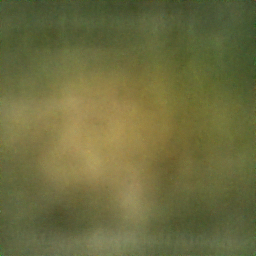


Batch 0, step 100, output 0:


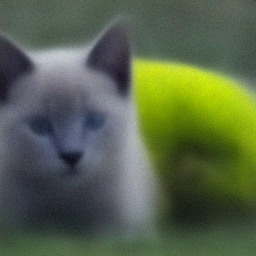


Batch 0, step 200, output 0:


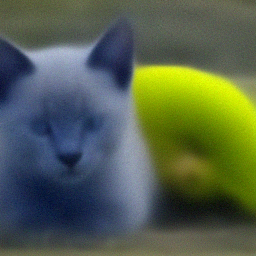


Batch 0, step 300, output 0:


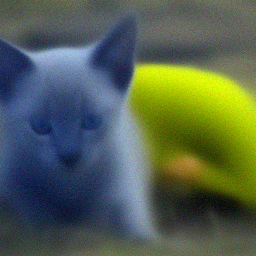


Batch 0, step 400, output 0:


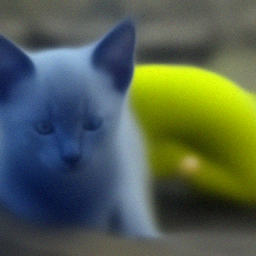


Batch 0, step 500, output 0:


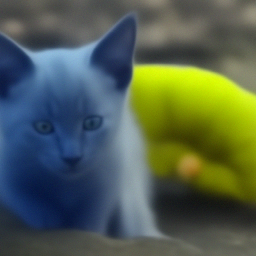


Batch 0, step 600, output 0:


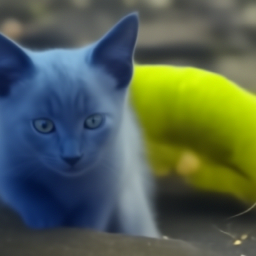


Batch 0, step 700, output 0:


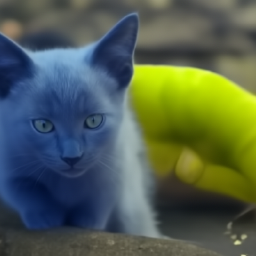


Batch 0, step 799, output 0:


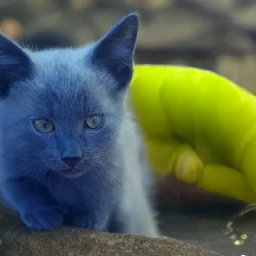

In [33]:
guided_diffusion_run()

In [71]:
images = []
filenames = os.listdir('results/guided/all/'+ prompt.replace(" ", "_") )
filenames = natsorted(filenames)


In [70]:
for filename in filenames:
    images.append(imageio.imread('results/guided/all/' + prompt.replace(" ", "_") + '/' + filename))
imageio.mimsave('results/guided/' + prompt.replace(" ", "_") + '.gif', images)

<img src="results/guided/a_blue_cat.gif" width="750" align="center">